In [ ]:
# © Begum Celebi, December 2025 
# --------------------------------------------------------
# BTC vs S&P 500 Portfolio Analysis with 10Y Yield as Risk-Free
# --------------------------------------------------------
# Date: 2025-12-27
# Data Source: Investing.com / Yahoo Finance
#
# =========================================================
# BTC vs S&P 500 Portfolio Analysis
# =========================================================
# Author: Begum Celebi
# Date: 2025-12-27
#
# Objective:
#   Analyze BTC and S&P 500 (US) with daily returns,
#   including 10-Year US Treasury yield as the risk-free rate.
#   Key points:
#       - Descriptive stats of daily returns
#       - Cumulative returns comparison
#       - 30-day rolling correlation (BTC vs S&P, BTC vs 10Y)
#       - 30-day rolling volatility comparison (BTC vs S&P)
#       - Histogram of daily returns
#       - Annual average correlation table
#       - Modern Portfolio Theory-based optimal allocation (BTC & S&P)
#
# Notes:
#   - Daily returns used for all calculations
#   - Annualized returns and volatility assume 252 trading days
#   - Risk-free rate is derived from average 10Y US Treasury yield
# =========================================================


--- Daily Returns Descriptive Stats ---

  Asset  Mean Daily Return (%)  Std Daily Return (%)
    BTC               0.098700              3.428056
S&P 500               0.055582              1.089682


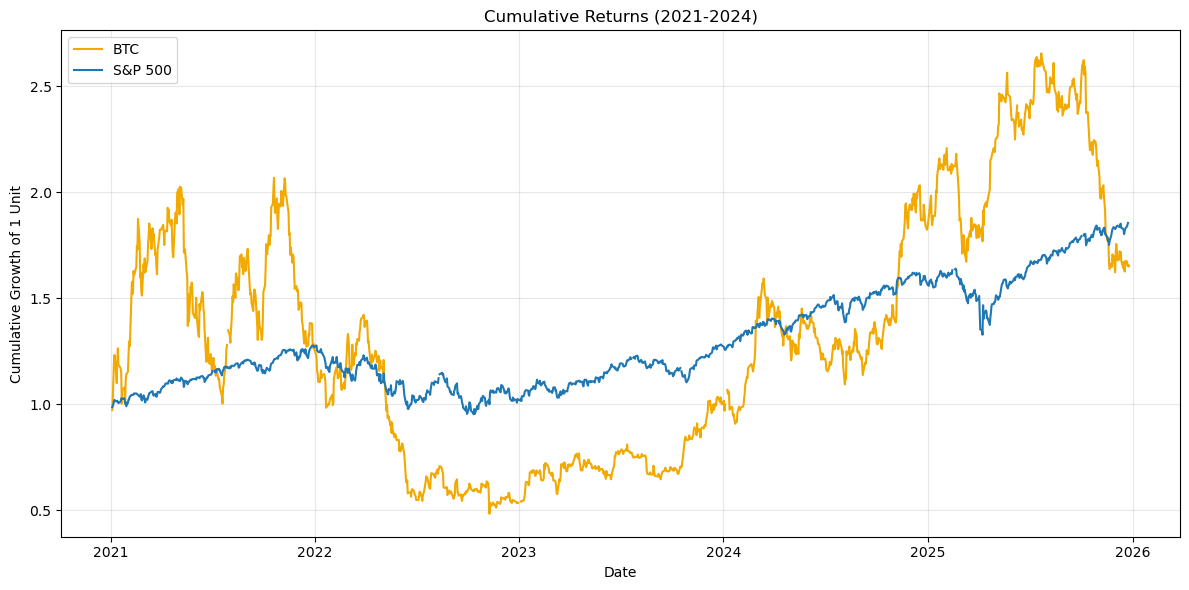

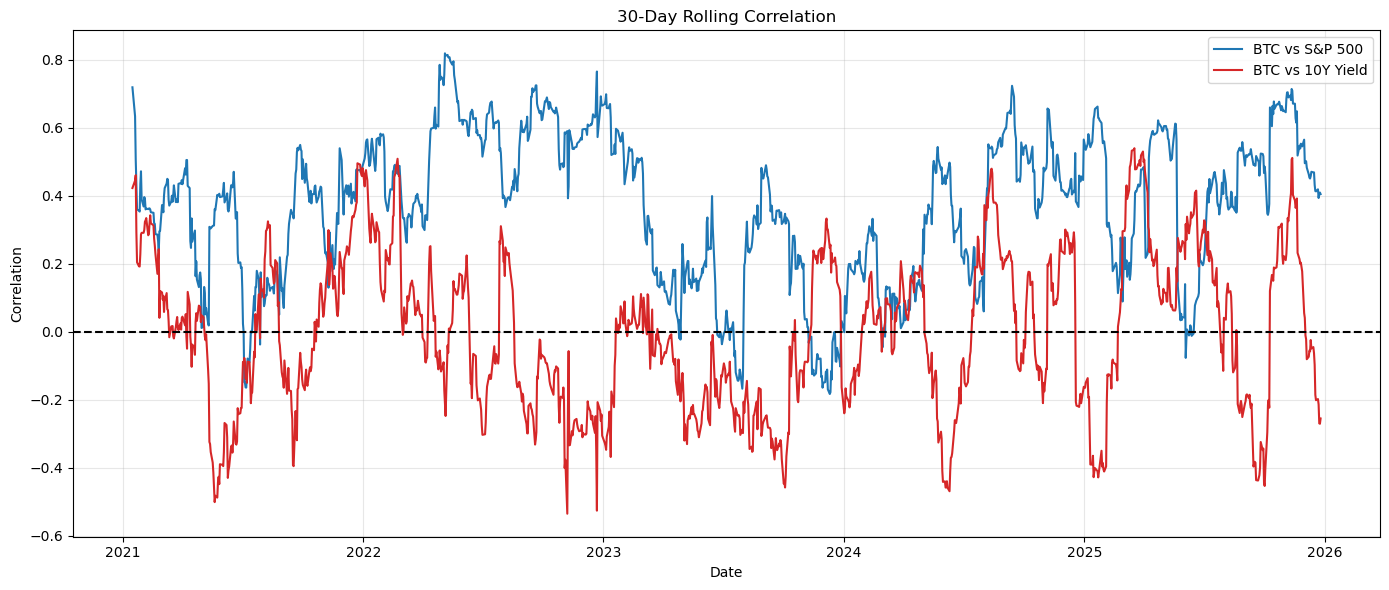

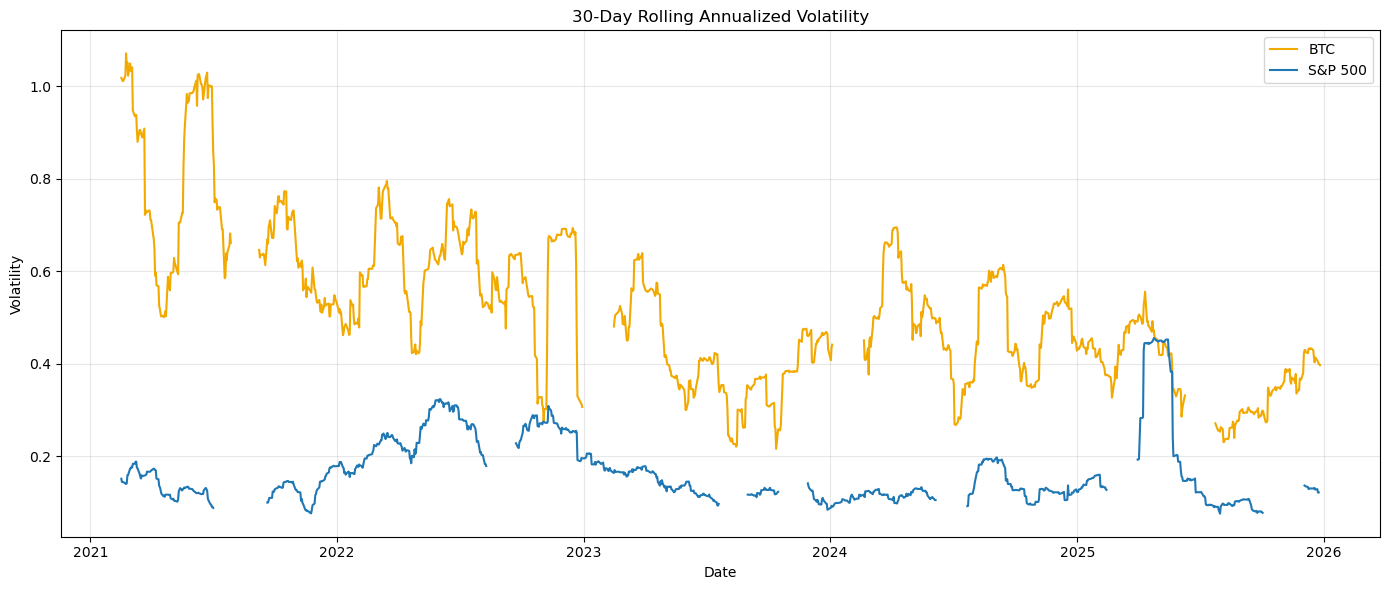

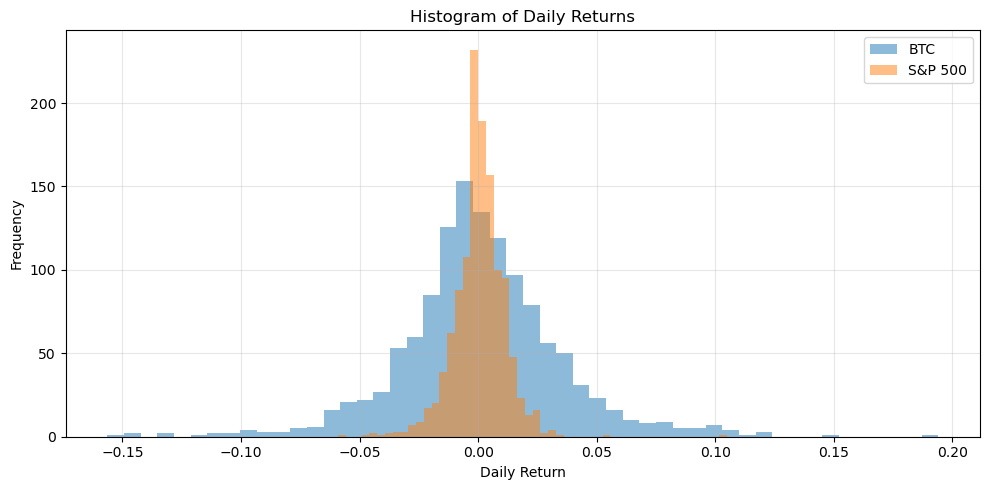


--- Annual Average Correlations ---

 Year  BTC vs S&P Avg Corr  BTC vs 10Y Avg Corr
 2021                0.299                0.018
 2022                0.559               -0.028
 2023                0.206               -0.109
 2024                0.330                0.027
 2025                0.431                0.069

--- Optimal Portfolio Allocation (BTC & S&P, 10Y as Risk-Free) ---

  Asset  Optimal Allocation (%)
    BTC               10.163551
S&P 500               89.836449

Expected Annual Return: 15.02%
Expected Annual Volatility: 18.38%
Expected Sharpe Ratio: 0.63
Risk-Free Rate (10Y yield): 3.36%


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------
# HELPER FUNCTION
# ------------------------
def clean_financial_number(x):
    if isinstance(x, str):
        x = x.strip().replace('%','').replace(',','')
        if '(' in x and ')' in x:
            x = '-' + x.replace('(','').replace(')','')
        try:
            return float(x)
        except:
            return np.nan
    return x

# ------------------------
# 1. LOAD DATA
# ------------------------
spy = pd.read_csv('spy_historical_data .csv')
spy['date'] = pd.to_datetime(spy['date'], dayfirst=True)
spy['spy_change'] = spy['spy_price_change'].apply(clean_financial_number)

btc = pd.read_csv('btc_historical-data .csv')
btc['date'] = pd.to_datetime(btc['date'], dayfirst=True)
btc['btc_change'] = btc['btc_price_change'].apply(clean_financial_number)

yield_data = pd.read_csv('us_10yr_yield .csv')
yield_data['date'] = pd.to_datetime(yield_data['date'], dayfirst=True)
yield_col = yield_data.columns[1]
yield_data['yield_clean'] = yield_data[yield_col].apply(clean_financial_number)
rf = yield_data['yield_clean'].mean() / 100  # Annualized risk-free rate

# ------------------------
# 2. MERGE DATA
# ------------------------
df = spy[['date','spy_change']].merge(
    btc[['date','btc_change']], on='date', how='inner'
)
df = df.sort_values('date').reset_index(drop=True)
df['year'] = df['date'].dt.year
df = df[df['year'] >= 2021]  # Exclude 2020 if desired

# Merge 10Y yield changes for correlation purposes
yield_data = yield_data.sort_values('date').reset_index(drop=True)
yield_data['yield_daily_change'] = yield_data['yield_clean'].diff() / 100
df = df.merge(yield_data[['date','yield_daily_change']], on='date', how='left')

# ------------------------
# 3. DESCRIPTIVE STATS
# ------------------------
daily_stats = pd.DataFrame({
    'Asset': ['BTC','S&P 500'],
    'Mean Daily Return (%)': [
        df['btc_change'].mean()*100,
        df['spy_change'].mean()*100
    ],
    'Std Daily Return (%)': [
        df['btc_change'].std()*100,
        df['spy_change'].std()*100
    ]
})
print("\n--- Daily Returns Descriptive Stats ---\n")
print(daily_stats.to_string(index=False))

# ------------------------
# 4. CUMULATIVE RETURNS
# ------------------------
df['btc_cum'] = (1 + df['btc_change']).cumprod()
df['spy_cum'] = (1 + df['spy_change']).cumprod()

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['btc_cum'], label='BTC', color='#f2a900')
plt.plot(df['date'], df['spy_cum'], label='S&P 500', color='#1f77b4')
plt.title('Cumulative Returns (2021-2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth of 1 Unit')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------
# 5. ROLLING 30-DAY CORRELATION
# ------------------------
window = 30
min_periods = 10
df['corr_btc_spy'] = df['btc_change'].rolling(window, min_periods=min_periods).corr(df['spy_change'])
df['corr_btc_yield'] = df['btc_change'].rolling(window, min_periods=min_periods).corr(df['yield_daily_change'])

plt.figure(figsize=(14,6))
plt.plot(df['date'], df['corr_btc_spy'], label='BTC vs S&P 500', color='#1f77b4')
plt.plot(df['date'], df['corr_btc_yield'], label='BTC vs 10Y Yield', color='#d62728')
plt.axhline(0, color='black', linestyle='--')
plt.title('30-Day Rolling Correlation')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------
# 6. ROLLING 30-DAY VOLATILITY (BTC vs S&P)
# ------------------------
df['btc_vol'] = df['btc_change'].rolling(window).std()*np.sqrt(252)
df['spy_vol'] = df['spy_change'].rolling(window).std()*np.sqrt(252)

plt.figure(figsize=(14,6))
plt.plot(df['date'], df['btc_vol'], label='BTC', color='#f2a900')
plt.plot(df['date'], df['spy_vol'], label='S&P 500', color='#1f77b4')
plt.title('30-Day Rolling Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------
# 7. HISTOGRAM OF DAILY RETURNS
# ------------------------
plt.figure(figsize=(10,5))
plt.hist(df['btc_change'], bins=50, alpha=0.5, label='BTC')
plt.hist(df['spy_change'], bins=50, alpha=0.5, label='S&P 500')
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------
# 8. ANNUAL AVERAGE CORRELATION TABLE
# ------------------------
summary_list = []
for year in sorted(df['year'].unique()):
    temp = df[df['year']==year]
    summary_list.append({
        'Year': year,
        'BTC vs S&P Avg Corr': round(temp['corr_btc_spy'].mean(),3),
        'BTC vs 10Y Avg Corr': round(temp['corr_btc_yield'].mean(),3)
    })
summary_df = pd.DataFrame(summary_list)
print("\n--- Annual Average Correlations ---\n")
print(summary_df.to_string(index=False))

# ------------------------
# 9. MODERN PORTFOLIO THEORY OPTIMIZATION (BTC & S&P)
# ------------------------
returns_risky = df[['btc_change','spy_change']].dropna()
mean_returns = returns_risky.mean() * 252  # annualized
cov_matrix = returns_risky.cov() * 252     # annualized

def neg_sharpe_risky(weights, mean_returns, cov_matrix, rf):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - rf) / port_vol
    return -sharpe

constraints = ({'type':'eq', 'fun': lambda x: np.sum(x)-1})
bounds = tuple((0,1) for _ in range(2))
init_guess = [0.5,0.5]

opt = minimize(neg_sharpe_risky, init_guess, args=(mean_returns, cov_matrix, rf),
               method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = opt.x
port_return = np.dot(optimal_weights, mean_returns)
port_vol = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
port_sharpe = (port_return - rf) / port_vol

allocation_table = pd.DataFrame({
    'Asset': ['BTC','S&P 500'],
    'Optimal Allocation (%)': [w*100 for w in optimal_weights]
})

print("\n--- Optimal Portfolio Allocation (BTC & S&P, 10Y as Risk-Free) ---\n")
print(allocation_table.to_string(index=False))
print(f"\nExpected Annual Return: {port_return:.2%}")
print(f"Expected Annual Volatility: {port_vol:.2%}")
print(f"Expected Sharpe Ratio: {port_sharpe:.2f}")
print(f"Risk-Free Rate (10Y yield): {rf:.2%}")
